<a href="https://colab.research.google.com/github/golnazads/ColabNotebooks/blob/main/astrollama_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bitsandbytes accelerate xformers einops langchain faiss-cpu transformers sentence-transformers
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.5/810.5 kB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 114.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━

In [ ]:
from typing import List
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig, BitsAndBytesConfig
import torch
from langchain.prompts import PromptTemplate
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains import ConversationalRetrievalChain, RetrievalQA
from langchain.callbacks.tracers import ConsoleCallbackHandler
from langchain_core.vectorstores import VectorStoreRetriever
from langchain.memory import ConversationBufferMemory
from langchain.vectorstores import FAISS

from openai import OpenAI
from google.colab import userdata

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)
if device == 'cuda':
    print(torch.cuda.get_device_name(0))

Device: cuda
Tesla V100-SXM2-16GB


In [ ]:
# either run this cell, which takes about 20 minutes
# or load the saved model
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path="universeTBD/astroLLaMa",
    quantization_config=bnb_config, device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path="universeTBD/astroLLaMa"
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_path = '/content/drive/MyDrive/astroLLaMa_model'
save_path_open_ai = '/content/drive/MyDrive/openai'
save_path_astroLLaMa = '/content/drive/MyDrive/astroLLaMa'

Mounted at /content/drive


In [ ]:
# save
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

In [ ]:
# load
model = AutoModelForCausalLM.from_pretrained(save_path)
tokenizer = AutoTokenizer.from_pretrained(save_path)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


### Text Geneneration vs Vector Embedding

Let input sentence be: The Apollo crater

Before processing the input sentence, it needs to be tokenized into individual tokens. Each token is then converted into a dense vector representation called a token embedding, which captures the semantic and syntactic properties of the token. Additionally, positional encodings are added to represent the position of each token in the input sequence.

For text generation, the output is the probability distribution over the vocabulary, which is then used to determine the next token. By iteratively sampling or selecting tokens from the probability distribution, we can generate a continuation of the input sentence, such as "The Apollo crater was named after NASA's Apollo moon missions."

For vector embedding, we want an embedding for each token in the input. The Transformer model consists of multiple layers, each applying self-attention and feed-forward operations. As the input passes through the layers, the model learns increasingly abstract and contextualized representations of the tokens. The output vector for each token is grabbed from the last layer of the Transformer model, which captures the most high-level and contextualized representation of the input. The dimensionality of the embeddings depends on the specific Transformer model architecture and the size of the hidden layers.

The reason the last layer is used for embedding is that it incorporates information from all the previous layers and has the ability to attend to all the tokens in the input sequence, making it suitable for capturing the overall meaning and context. For embedding tasks, the pre-trained Transformer model is often fine-tuned on a specific downstream task using labeled data, allowing the model to adapt its representations to the specific requirements of the task.

###Text Generation

In [ ]:
from transformers import pipeline

generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
)

In [ ]:
def split_string(text, max_length):
    """Splits a string on whitespace, respecting a maximum substring length."""
    substrings = []
    current_substring = ""
    current_length = 0

    for word in text.split():
        if current_length == max_length:
            substrings.append(current_substring.strip())
            current_substring = ""
            current_length = 0
        current_substring += " " + word
        current_length += 1

    # Add the last substring (if any)
    if current_substring:
        substrings.append(current_substring.strip())

    return substrings

In [ ]:
prompt = """
The Magellanic Stream (MS) - an enormous ribbon of gas spanning 140∘ of the southern sky trailing the Magellanic Clouds - has
been exquisitely mapped in the five decades since its discovery. However, despite concerted efforts, no stellar counterpart to the MS
has been conclusively identified. This stellar stream would reveal the distance and 6D kinematics of the MS, constraining its
formation and the past orbital history of the Clouds. We
"""

generated_text = generator(
    prompt,
    do_sample=True,
    max_length=1024
)
generated_text = generated_text[0]['generated_text']

# reply = generate_completion(prompt)
for text in generated_text.split('\n'):
  if text.count(' ') < 25:
    print(text)
  else:
    for t in split_string(text, 25):
      print(t)


The Magellanic Stream (MS) - an enormous ribbon of gas spanning 140∘ of the southern sky trailing the Magellanic Clouds - has
been exquisitely mapped in the five decades since its discovery. However, despite concerted efforts, no stellar counterpart to the MS
has been conclusively identified. This stellar stream would reveal the distance and 6D kinematics of the MS, constraining its
formation and the past orbital history of the Clouds. We
perform the first search for stellar structures consistent with the known gaseous stream in ultradeep proper motion and velocity
surveys. Using Gaia DR2 data of \sim410 million objects along with Gaia DR2 proper motions and trigonometric parallaxes of
\sim1.3 million stars, we identify at the 4.8$\sigma$ level a tentative stream-like structure over a vast area of \sim10500 deg$^2$
in the southeastern sky, extending over 700 deg around the Sun. The spatial extent and velocity of this putative stellar stream
are consistent with predictions of tidal str

###Embedding

In [ ]:
import pandas as pd

# Loading dataframe
df = pd.read_csv('sample_data/Moon_Crater_Apollo_Text_Vectors_128.csv')
# Checking df length
print('Dataframe Length:', len(df), 'rows')

sentences = df['text'].tolist()

Dataframe Length: 739 rows


In [ ]:
import numpy as np
import pickle

def save_data(embeddings, similarities, filename_prefix):
    np.save(f"{filename_prefix}_embeddings.npy", embeddings)
    with open(f"{filename_prefix}_similarities.pkl", "wb") as f:
        pickle.dump(similarities, f)

def load_data(filename_prefix):
    embeddings = np.load(f"{filename_prefix}_embeddings.npy")
    with open(f"{filename_prefix}_similarities.pkl", "rb") as f:
        similarities = pickle.load(f)
    return embeddings, similarities

###Embedding astroLLaMa

In [ ]:
def get_embedding(sentence):
  # tokenize the sentence
  encoded_sentence = tokenizer(
      sentence,
      return_tensors="pt",
      return_token_type_ids=False,
      padding=True,
      truncation=True,
      max_length=4096
  )

  encoded_sentence.to(model.device)
  outputs = model(**encoded_sentence, output_hidden_states=True)

  sentence_embedding = outputs["hidden_states"][-1][:, 1:, ...]

  return sentence_embedding.mean(1).detach().cpu().numpy()

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# embeddings for each sentence
embeddings = np.array([get_embedding(sentence) for sentence in sentences])
# 2D array is needed for cosine similarity
embeddings = embeddings.squeeze(axis=1)

# cosine similarity
pairwise_similarities = cosine_similarity(embeddings)

save_data(embeddings, pairwise_similarities, save_path_astroLLaMa)

In [ ]:
embeddings, pairwise_similarities = load_data(save_path_astroLLaMa)

###Embedding OpenAI

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

def get_embedding_openai(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

embeddings_openai = []
for i, sentence in enumerate(sentences):
  embeddings_openai.append(get_embedding_openai(sentence))
  if i % 100 == 0:
    print(i)

embeddings_openai = np.array(embeddings_openai)

# cosine similarity
pairwise_similarities_openai = cosine_similarity(embeddings_openai)

save_data(embeddings_openai, pairwise_similarities_openai, save_path_open_ai)

0
100
200
300
400
500
600
700


In [ ]:
embeddings_openai, pairwise_similarities_openai = load_data(save_path_open_ai)

###Visualization

In [ ]:
def normalize(similarities):
  normalized_similarities = (similarities - np.min(similarities)) / (np.max(similarities) - np.min(similarities))
  return normalized_similarities

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_similarity_distributions_openai_centeric(astroLLaMa_similarities, openai_similarities, num_bins=10, num_points=1000):

    # Flatten the upper triangular part of the similarity matrices
    astroLLaMa_similarities_flat = astroLLaMa_similarities[np.triu_indices(astroLLaMa_similarities.shape[0], k=1)]
    openai_similarities_flat = openai_similarities[np.triu_indices(openai_similarities.shape[0], k=1)]

    # Create equal-width bins based on openai similarities
    bins = np.linspace(openai_similarities_flat.min(), openai_similarities_flat.max(), num_bins + 1)

    # Assign astroLLaMa and OpenAI similarities to bins
    astroLLaMa_bin_indices = np.digitize(astroLLaMa_similarities_flat, bins)
    openai_bin_indices = np.digitize(openai_similarities_flat, bins)

    # Calculate the shift for each bin
    shift_factor = 50  # Adjust the shift factor as needed
    shifts = np.arange(num_bins) * shift_factor

    # Plot the distribution for each bin using KDE
    plt.figure(figsize=(8, 6))
    max_density = 0

    extend_factor = 0.05

    for i in range(1, num_bins + 1):
        # astroLLaMa_bin_data = astroLLaMa_similarities_flat[astroLLaMa_bin_indices == i]
        astroLLaMa_bin_data = astroLLaMa_similarities_flat[openai_bin_indices == i]
        openai_bin_data = openai_similarities_flat[openai_bin_indices == i]

        if len(astroLLaMa_bin_data) > 0:
            # creates a Gaussian kernel density estimator which is fitted to the data
            astroLLaMa_kde = gaussian_kde(astroLLaMa_bin_data)
            # generates an array of evenly spaced points using np.linspace
            # the range of points extends beyond the current bin boundaries by extend_factor to mimic the figure in the paper
            # num_points determines the number of points to generate within the range
            x_astroLLaMa_extended = np.linspace(bins[i-1] - extend_factor, bins[i] + extend_factor, num_points)
            # evaluates the kde at the points in x_astroLLaMa_extended to obtain the estimated probability density values
            y_astroLLaMa_extended = astroLLaMa_kde(x_astroLLaMa_extended)
            x_astroLLaMa = x_astroLLaMa_extended
            # contains the probability density estimates for the points within the range of x_astroLLaMa
            # truncats the y_astroLLaMa_extended array to match the range of x_astroLLaMa
            y_astroLLaMa = y_astroLLaMa_extended[(x_astroLLaMa_extended >= x_astroLLaMa[0]) & (x_astroLLaMa_extended <= x_astroLLaMa[-1])]
            max_density = max(max_density, np.max(y_astroLLaMa))
            plt.plot(x_astroLLaMa, y_astroLLaMa + shifts[i-1], color='red', label=f'astroLLaMa' if i == 1 else "_nolegend_")
            plt.fill_between(x_astroLLaMa, shifts[i-1], y_astroLLaMa + shifts[i-1], color='red', alpha=0.3)


        if len(openai_bin_data) > 0:
            openai_kde = gaussian_kde(openai_bin_data)
            x_openai = np.linspace(bins[i-1], bins[i], num_points)
            y_openai = openai_kde(x_openai)
            max_density = max(max_density, np.max(y_openai))
            plt.plot(x_openai, y_openai + shifts[i-1], color='blue', label=f'GPT3(ada)' if i == 1 else "_nolegend_")
            plt.fill_between(x_openai, shifts[i-1], y_openai + shifts[i-1], color='blue', alpha=0.3)

    plt.ylim(-10, max_density + shifts[-1] + 0.01)
    plt.legend(loc='upper left')
    plt.xlabel('Pairwise cosine similarity')
    plt.ylabel('Density + Shift')
    plt.title('Distribution of Pairwise Cosine Similarities -- openAI Based (astroLLaMa vs. GPT3)')
    plt.tight_layout()
    plt.show()

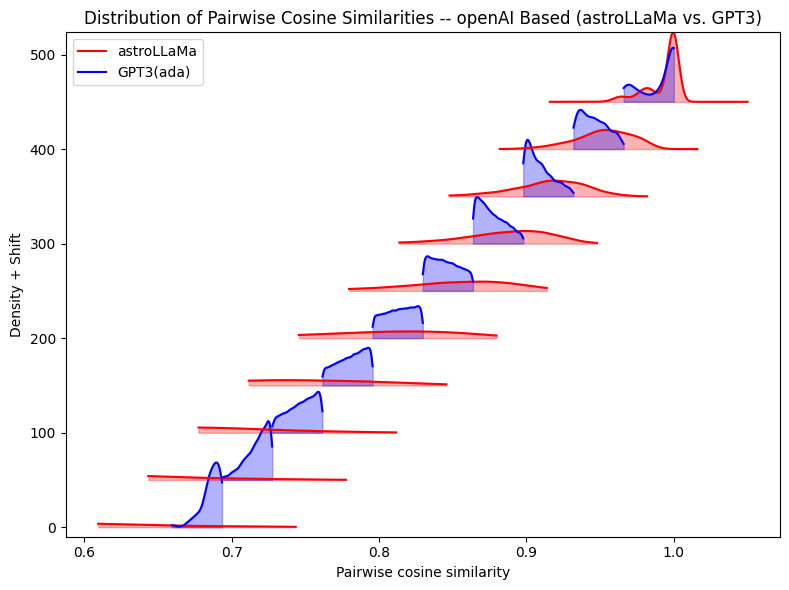

In [ ]:
plot_similarity_distributions_openai_centeric(pairwise_similarities, pairwise_similarities_openai)

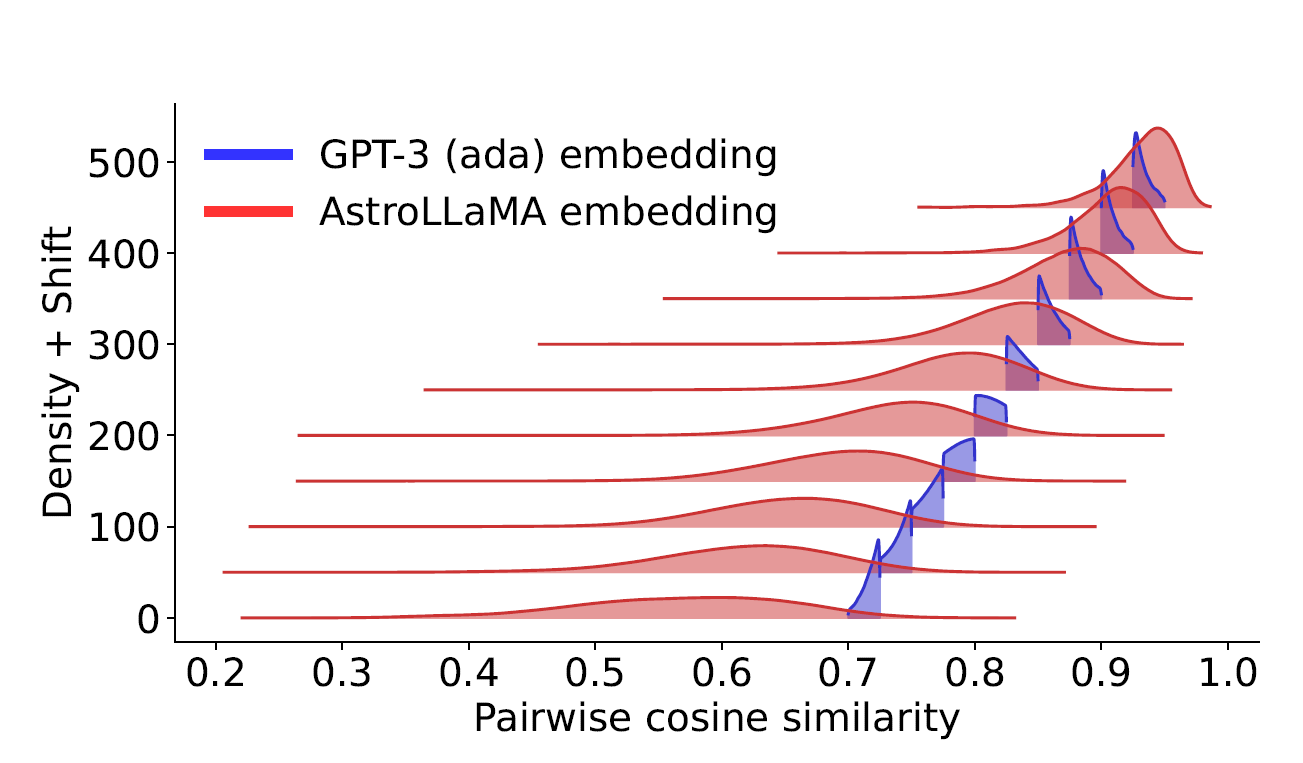

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_similarity_distributions(astroLLaMa_similarities, openai_similarities):

    # Flatten the upper triangular part of the similarity matrices
    astroLLaMa_similarities_flat = astroLLaMa_similarities[np.triu_indices(astroLLaMa_similarities.shape[0], k=1)]
    openai_similarities_flat = openai_similarities[np.triu_indices(openai_similarities.shape[0], k=1)]

    astroLLaMa_kde = gaussian_kde(astroLLaMa_similarities_flat)
    x_astroLLaMa = np.linspace(np.min(astroLLaMa_similarities_flat), np.max(astroLLaMa_similarities_flat), 1000)
    y_astroLLaMa = astroLLaMa_kde(x_astroLLaMa)
    plt.plot(x_astroLLaMa, y_astroLLaMa, color='red', label=f'astroLLaMa')
    plt.fill_between(x_astroLLaMa, y_astroLLaMa, color='red', alpha=0.3)


    openai_kde = gaussian_kde(openai_similarities_flat)
    x_openai = np.linspace(np.min(openai_similarities_flat), np.max(openai_similarities_flat), 1000)
    y_openai = openai_kde(x_openai)
    plt.plot(x_openai, y_openai, color='blue', label=f'GPT3(ada)')
    plt.fill_between(x_openai, y_openai, color='blue', alpha=0.3)


    plt.legend(loc='upper left')
    plt.xlabel('Pairwise cosine similarity')
    plt.ylabel('Density')
    plt.title('Distribution of Pairwise Cosine Similarities (astroLLaMa vs. GPT3)')
    plt.tight_layout()
    plt.show()

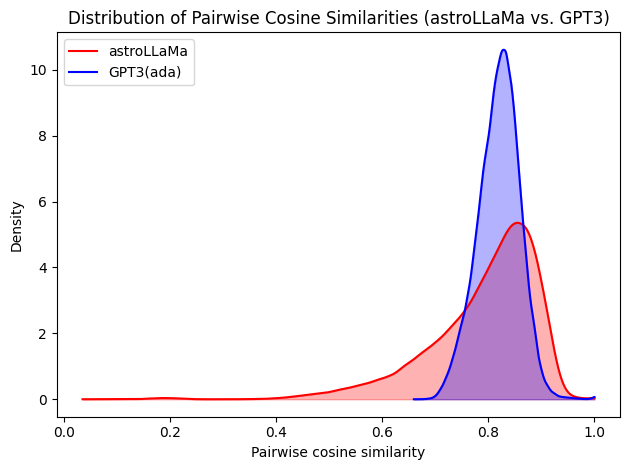

In [ ]:
plot_similarity_distributions(pairwise_similarities, pairwise_similarities_openai)

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_similarity_distributions_astroLLaMa_centeric(astroLLaMa_similarities, openai_similarities, num_bins=10, num_points=1000):

    # Flatten the upper triangular part of the similarity matrices
    astroLLaMa_similarities_flat = astroLLaMa_similarities[np.triu_indices(astroLLaMa_similarities.shape[0], k=1)]
    openai_similarities_flat = openai_similarities[np.triu_indices(openai_similarities.shape[0], k=1)]

    # Create equal-width bins based on astroLLaMa similarities
    bins = np.linspace(astroLLaMa_similarities_flat.min(), astroLLaMa_similarities_flat.max(), num_bins + 1)

    # Assign astroLLaMa and OpenAI similarities to bins
    astroLLaMa_bin_indices = np.digitize(astroLLaMa_similarities_flat, bins)
    openai_bin_indices = np.digitize(openai_similarities_flat, bins)

    # Calculate the shift for each bin
    shift_factor = 50  # Adjust the shift factor as needed
    shifts = np.arange(num_bins) * shift_factor

    # Plot the distribution for each bin using KDE
    plt.figure(figsize=(8, 6))
    max_density = 0

    extend_factor = 0.05

    for i in range(1, num_bins + 1):
        astroLLaMa_bin_data = astroLLaMa_similarities_flat[astroLLaMa_bin_indices == i]
        openai_bin_data = openai_similarities_flat[astroLLaMa_bin_indices == i]

        if len(astroLLaMa_bin_data) > 0:
            # creates a Gaussian kernel density estimator which is fitted to the data
            astroLLaMa_kde = gaussian_kde(astroLLaMa_bin_data)
            # generates an array of evenly spaced points using np.linspace
            # the range of points extends beyond the current bin boundaries by extend_factor to mimic the figure in the paper
            # num_points determines the number of points to generate within the range
            x_astroLLaMa_extended = np.linspace(bins[i-1] - extend_factor, bins[i] + extend_factor, num_points)
            # evaluates the kde at the points in x_astroLLaMa_extended to obtain the estimated probability density values
            y_astroLLaMa_extended = astroLLaMa_kde(x_astroLLaMa_extended)
            x_astroLLaMa = x_astroLLaMa_extended
            # contains the probability density estimates for the points within the range of x_astroLLaMa
            # truncats the y_astroLLaMa_extended array to match the range of x_astroLLaMa
            y_astroLLaMa = y_astroLLaMa_extended[(x_astroLLaMa_extended >= x_astroLLaMa[0]) & (x_astroLLaMa_extended <= x_astroLLaMa[-1])]
            max_density = max(max_density, np.max(y_astroLLaMa))
            plt.plot(x_astroLLaMa, y_astroLLaMa + shifts[i-1], color='red', label=f'astroLLaMa' if i == 1 else "_nolegend_")
            plt.fill_between(x_astroLLaMa, shifts[i-1], y_astroLLaMa + shifts[i-1], color='red', alpha=0.3)


        if len(openai_bin_data) > 0:
            openai_kde = gaussian_kde(openai_bin_data)
            x_openai = np.linspace(bins[i-1], bins[i], num_points)
            y_openai = openai_kde(x_openai)
            max_density = max(max_density, np.max(y_openai))
            plt.plot(x_openai, y_openai + shifts[i-1], color='blue', label=f'GPT3(ada)' if i == 1 else "_nolegend_")
            plt.fill_between(x_openai, shifts[i-1], y_openai + shifts[i-1], color='blue', alpha=0.3)

    plt.ylim(-10, max_density + shifts[-1] + 0.01)
    plt.legend(loc='upper left')
    plt.xlabel('Pairwise cosine similarity')
    plt.ylabel('Density + Shift')
    plt.title('Distribution of Pairwise Cosine Similarities -- astroLLaMa Based (astroLLaMa vs. GPT3) --  astroLLaMa Centeric')
    plt.tight_layout()
    plt.show()

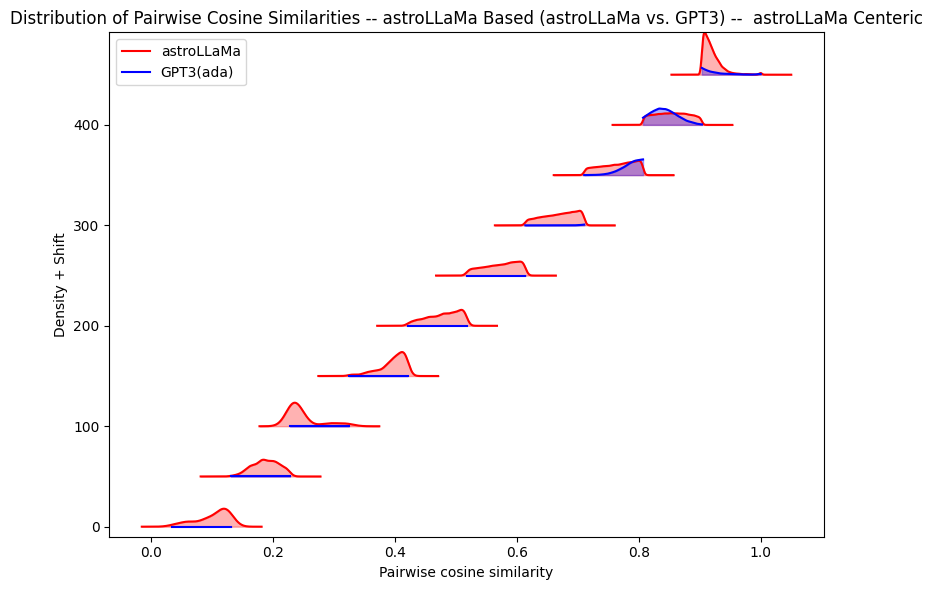

In [ ]:
plot_similarity_distributions_astroLLaMa_centeric(pairwise_similarities, pairwise_similarities_openai)